In [1]:
from qutip import *
import numpy as np
import scipy as sp
import math
import matplotlib.pyplot as plt
from scipy.special import genlaguerre as L
from scipy.optimize import root_scalar as root

D:\Mark\Python\lib\site-packages\qutip\__init__.py:65: UserWarning: The new version of Cython, (>= 3.0.0) is not supported.
  warnings.warn(


In [2]:
def Omega(n,m,eta):
    return np.abs(np.exp(-eta**2/2.0) * eta**(np.abs(m)) * (math.factorial(n)/math.factorial(n+m))**(np.sign(m)/2.0) \
        * L(n,np.abs(m))(eta**2))             #returns unitless rabi rate of transition n -> n+m given Lamb-Dicke Parameter

def prob(n,nbar):
    return 1.0/(nbar+1)*(nbar/(nbar+1))**n    #returns prob of being in state n given nbar
    
eta = 0.1
Ncut = 1000
omegas = np.zeros(Ncut)
#probs = np.zeros(Ncut)
#nbar = 10
for n in range(Ncut):
    omegas[n] = Omega(n,0,eta)
    #probs[n] = prob(n,nbar)

D:\Mark\Python\lib\site-packages\scipy\special\_orthogonal.py:651: RuntimeWarning: invalid value encountered in double_scalars
  hn = _gam(n + alpha + 1) / _gam(n + 1)
D:\Mark\Python\lib\site-packages\scipy\special\_orthogonal.py:140: RuntimeWarning: invalid value encountered in multiply
  np.poly1d.__init__(self, poly.coeffs * float(kn))
D:\Mark\Python\lib\site-packages\scipy\special\_orthogonal.py:196: RuntimeWarning: overflow encountered in true_divide
  w = 1.0 / (fm * dy)
D:\Mark\Python\lib\site-packages\scipy\special\_orthogonal.py:202: RuntimeWarning: invalid value encountered in multiply
  w *= mu0 / w.sum()
D:\Mark\Python\lib\site-packages\scipy\special\_orthogonal.py:127: RuntimeWarning: invalid value encountered in double_scalars
  equiv_weights = [weights[k] / wfunc(roots[k]) for
D:\Mark\Python\lib\site-packages\scipy\special\_orthogonal.py:196: RuntimeWarning: divide by zero encountered in true_divide
  w = 1.0 / (fm * dy)
D:\Mark\Python\lib\site-packages\scipy\special\_or

In [3]:
hbar = sp.constants.hbar
h = sp.constants.h
c = sp.constants.c
e = sp.constants.e
eVtoJ = 1.602176634e-19
amutokg = 1.66053906660e-27

def expE(nbar, omega, Ncut):
    expE = 0.0
    for n in range(Ncut):
        expE += prob(n,nbar)*hbar*omega*(0.5+n)
    return expE

def dopAndStark(nbar): #gives instantaneous doppler and stark shift in angular frequency units
    Ncut = 1201
    omega = 2.0*np.pi*778e3 #Lange
    Omegarf = 2.0*np.pi*13e6 #Lange
    m = 170.936331517*amutokg
    alpha = 5.89e-40 #J m^2 V^-2 E2 transition (Lange)
    nu0 = 688358979309307.82 #Hz E2 transition (Huntemann)
    return -2.0*np.pi*nu0*expE(nbar, omega, Ncut)*(3.0/(m*c**2) + (alpha/(h*nu0))*(3.0*m*Omegarf**2/(2.0*e**2)))
#from Lange eqns 2.11 and 2.12

In [7]:
def rhoee(psi):
    return (abs(psi[1]))**2.0

def psi(g,e):
    return np.array([g, e])

def pulse(t, Omega0, delta, phi0, phi1):
    Omega = np.sqrt(Omega0**2 + delta**2)
    
    if Omega == 0.0:
        U = np.array([[1.0 , 0.0],
                      [0.0 , 1.0]])
        
    else:
        U = np.array([[np.cos(Omega*t/2.0) -(1.0j*delta/Omega)*np.sin(Omega*t/2.0), (1.0j*Omega0/Omega)*np.sin(Omega*t/2.0)],
                     [(1.0j*Omega0/Omega)*np.sin(Omega*t/2.0) , np.cos(Omega*t/2.0) + (1.0j*delta/Omega)*np.sin(Omega*t/2.0)]])
    
    V1 = np.array([[1.0 , 0.0],
                   [0.0 , np.exp(-1.0j*phi1)]])
    
    V0 = np.array([[1.0 , 0.0],
                   [0.0 , np.exp(1.0j*phi0)]])
    
    return np.exp(1.0j*delta*t/2.0)*V1@U@V0

In [8]:
def HRJumperrSig(deld, psi0, t, T, delPrime, Omega0):
    pi2PhaseInjP = pulse(0.0, 0.0, 0.0, 0.0, np.pi/2.0)
    pi2PhaseInjM = pulse(0.0, 0.0, 0.0, 0.0, -np.pi/2.0)
    pulse1 = pulse(t, Omega0, delPrime, 0.0, 0.0)
    pulse2 = pulse(2.0*t, -Omega0, delPrime, 0.0, 0.0)
    pulse3 = pulse(t, Omega0, delPrime, 0.0, 0.0)
    freeEvo = pulse(T, 0.0, deld, 0.0, 0.0)
    return rhoee(pulse3@pulse2@freeEvo@pi2PhaseInjP@pulse1@psi0) - rhoee(pulse3@pulse2@freeEvo@pi2PhaseInjM@pulse1@psi0)

def RSerrSig(deld, psi0, t1, T, t2, delPrime, Omega0):
    pulse1 = pulse(t1, Omega0, delPrime, 0.0, 0.0)
    pulse2 = pulse(t2, Omega0, delPrime, 0.0, 0.0)
    freeEvo = pulse(T, 0.0, deld, 0.0, 0.0)
    pi2PhaseInjP = pulse(0.0, 0.0, 0.0, 0.0, np.pi/2.0)
    pi2PhaseInjM = pulse(0.0, 0.0, 0.0, 0.0, -np.pi/2.0)
    
    return rhoee(pulse2@freeEvo@pi2PhaseInjP@pulse1@psi0) - rhoee(pulse2@freeEvo@pi2PhaseInjM@pulse1@psi0)

In [19]:
psi0 = psi(1.0, 0.0)
t1 = np.pi/2.0
t2 = t1
Omega0 = 1.0 #hz
T = 10.0

pts = 80
delPs = np.linspace(0, 1.5,pts)
deltas = np.zeros(pts)

guessTol = 10.0e-2
x0 = -0.1
x1 = 0.1

for ii in range(pts):
    deltas[ii] = sp.optimize.root_scalar(RSerrSig, args=(psi0, t1, T, t2, delPs[ii], Omega0), bracket=[x0,x1]).root
    print(deltas[ii])
    x0 = deltas[ii] - guessTol
    x1 = deltas[ii] + guessTol
    print(x0,x1)

0.0
-0.1 0.1
-0.003797402732740368
-0.10379740273274038 0.09620259726725963
-0.0075944118416200615
-0.10759441184162007 0.09240558815837994
-0.01139063423401275
-0.11139063423401276 0.08860936576598726
-0.01518567787808176
-0.11518567787808176 0.08481432212191825
-0.018979152329059248
-0.11897915232905926 0.08102084767094075
-0.02277066925059894
-0.12277066925059894 0.07722933074940107
-0.02655984292961152
-0.12655984292961153 0.07344015707038848
-0.030346290783024685
-0.13034629078302468 0.06965370921697532
-0.03412963385495505
-0.13412963385495505 0.06587036614504496
-0.037909497302834674
-0.1379094973028347 0.06209050269716533
-0.04168551087109744
-0.14168551087109743 0.058314489128902566
-0.045457309351099
-0.14545730935109902 0.05454269064890101
-0.04922453302602197
-0.14922453302602198 0.050775466973978035
-0.05298682809959835
-0.15298682809959835 0.047013171900401655
-0.05674384710757106
-0.15674384710757105 0.04325615289242894
-0.060495249310905636
-0.16049524931090564 0.039504

In [20]:
psi0 = psi(1.0, 0.0)
t1 = np.pi/2.0
t2 = 3.0*t1
Omega0 = 1.0 #hz
T = 10.0

pts = 80
delPs = np.linspace(0, 1.5,pts)
delta1s = np.zeros(pts)

guessTol = 10.0e-2
x0 = -0.1
x1 = 0.1

for ii in range(pts):
    delta1s[ii] = sp.optimize.root_scalar(RSerrSig, args=(psi0, t1, T, t2, delPs[ii], Omega0), bracket=[x0,x1]).root
    print(delta1s[ii])
    x0 = delta1s[ii] - guessTol
    x1 = delta1s[ii] + guessTol
    print(x0,x1)

0.0
-0.1 0.1
-2.148551026747439e-06
-0.10000214855102675 0.09999785144897326
-1.7141496936649075e-05
-0.10001714149693665 0.09998285850306336
-5.759103720749636e-05
-0.1000575910372075 0.09994240896279251
-0.00013565578679695955
-0.10013565578679696 0.09986434421320305
-0.00026284007698926574
-0.10026284007698927 0.09973715992301074
-0.0004498221102581884
-0.1004498221102582 0.09955017788974181
-0.0007063168335933156
-0.10070631683359332 0.09929368316640669
-0.001040976828182541
-0.10104097682818254 0.09895902317181747
-0.0014613319053674305
-0.10146133190536744 0.09853866809463258
-0.0019737658049505335
-0.10197376580495054 0.09802623419504947
-0.0025835264948140925
-0.1025835264948141 0.09741647350518591
-0.0032947652500874914
-0.1032947652500875 0.09670523474991251
-0.004110598928133585
-0.1041105989281336 0.09588940107186641
-0.005033189619712461
-0.10503318961971246 0.09496681038028755
-0.006063836052934983
-0.10606383605293498 0.09393616394706503
-0.007203071641424635
-0.10720307

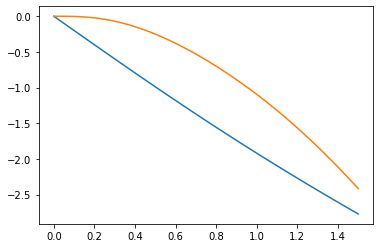

In [21]:
plt.plot(delPs, T*deltas)
plt.plot(delPs, T*delta1s)

In [31]:
psi0 = psi(1.0, 0.0)
t = np.pi/2.0
Omega0 = 1.0 #hz
T = 10.0

pts = 80
delPs = np.linspace(0, 1.5,pts)
delta2s = np.zeros(pts)

guessTol = 10.0e-2
x0 = -0.001
x1 = 0.001

for ii in range(pts):
    delta2s[ii] = sp.optimize.root_scalar(HRJumperrSig, args=(psi0, t, T, delPs[ii], Omega0), bracket=[x0,x1]).root
    print(delta2s[ii])
    x0 = delta2s[ii] - guessTol
    x1 = delta2s[ii] + guessTol
    print(x0,x1)

0.0
-0.1 0.1
-2.7356555885172828e-06
-0.10000273565558852 0.09999726434441149
-2.182641538855584e-05
-0.10002182641538857 0.09997817358461145
-7.333678508951815e-05
-0.10007333678508952 0.09992666321491049
-0.000172766287412492
-0.10017276628741249 0.09982723371258752
-0.00033480601387194314
-0.10033480601387194 0.09966519398612807
-0.0005731380794147277
-0.10057313807941473 0.09942686192058528
-0.0009002863210556543
-0.10090028632105566 0.09909971367894435
-0.0013275226253637495
-0.10132752262536375 0.09867247737463626
-0.001864829404801424
-0.10186482940480143 0.09813517059519858
-0.0025209154908188485
-0.10252091549081885 0.09747908450918116
-0.003303280265328892
-0.1033032802653289 0.09669671973467112
-0.004218319398880398
-0.1042183193988804 0.0957816806011196
-0.005271465079133239
-0.10527146507913325 0.09472853492086676
-0.00646735399995512
-0.10646735399995512 0.09353264600004489
-0.0078100174846827955
-0.1078100174846828 0.09218998251531721
-0.00930308977490627
-0.109303089774

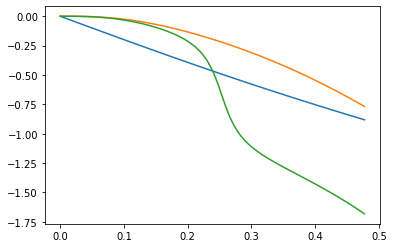

In [33]:
plt.plot(delPs/np.pi, T*deltas/np.pi)
plt.plot(delPs/np.pi, T*delta1s/np.pi)
plt.plot(delPs/np.pi, T*delta2s/np.pi)

(-0.3, 0.01)

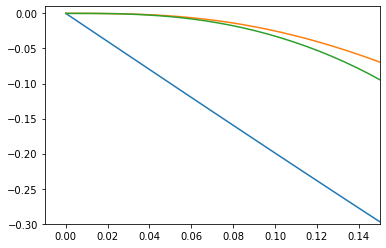

In [36]:
plt.plot(delPs/np.pi, T*deltas/np.pi)
plt.plot(delPs/np.pi, T*delta1s/np.pi)
plt.plot(delPs/np.pi, T*delta2s/np.pi)
plt.xlim([-0.01,0.15])
plt.ylim([-0.3,0.01])

In [37]:
def HRJumperrSigb(deld, psi0, t, T, Delta, Omega0):
    delprime = deld-Delta
    pi2PhaseInjP = pulse(0.0, 0.0, 0.0, 0.0, np.pi/2.0)
    pi2PhaseInjM = pulse(0.0, 0.0, 0.0, 0.0, -np.pi/2.0)
    pulse1 = pulse(t, Omega0, delPrime, 0.0, 0.0)
    pulse2 = pulse(2.0*t, -Omega0, delPrime, 0.0, 0.0)
    pulse3 = pulse(t, Omega0, delPrime, 0.0, 0.0)
    freeEvo = pulse(T, 0.0, deld, 0.0, 0.0)
    return rhoee(pulse3@pulse2@freeEvo@pi2PhaseInjP@pulse1@psi0) - rhoee(pulse3@pulse2@freeEvo@pi2PhaseInjM@pulse1@psi0)

def RSerrSigb(deld, psi0, t1, T, t2, Delta, Omega0):
    delprime = deld-Delta
    pulse1 = pulse(t1, Omega0, delPrime, 0.0, 0.0)
    pulse2 = pulse(t2, Omega0, delPrime, 0.0, 0.0)
    freeEvo = pulse(T, 0.0, deld, 0.0, 0.0)
    pi2PhaseInjP = pulse(0.0, 0.0, 0.0, 0.0, np.pi/2.0)
    pi2PhaseInjM = pulse(0.0, 0.0, 0.0, 0.0, -np.pi/2.0)
    
    return rhoee(pulse2@freeEvo@pi2PhaseInjP@pulse1@psi0) - rhoee(pulse2@freeEvo@pi2PhaseInjM@pulse1@psi0)

In [38]:
psi0 = psi(1.0, 0.0)
t1 = np.pi/2.0
t2 = t1
Omega0 = 1.0 #hz
T = 10.0

pts = 80
delPs = np.linspace(0, 1.5,pts)
deltas = np.zeros(pts)

guessTol = 10.0e-2
x0 = -0.1
x1 = 0.1

for ii in range(pts):
    deltas[ii] = sp.optimize.root_scalar(RSerrSig, args=(psi0, t1, T, t2, delPs[ii], Omega0), bracket=[x0,x1]).root
    print(deltas[ii])
    x0 = deltas[ii] - guessTol
    x1 = deltas[ii] + guessTol
    print(x0,x1)

0.0
-0.1 0.1
-0.003797402732740368
-0.10379740273274038 0.09620259726725963
-0.0075944118416200615
-0.10759441184162007 0.09240558815837994
-0.01139063423401275
-0.11139063423401276 0.08860936576598726
-0.01518567787808176
-0.11518567787808176 0.08481432212191825
-0.018979152329059248
-0.11897915232905926 0.08102084767094075
-0.02277066925059894
-0.12277066925059894 0.07722933074940107
-0.02655984292961152
-0.12655984292961153 0.07344015707038848
-0.030346290783024685
-0.13034629078302468 0.06965370921697532
-0.03412963385495505
-0.13412963385495505 0.06587036614504496
-0.037909497302834674
-0.1379094973028347 0.06209050269716533
-0.04168551087109744
-0.14168551087109743 0.058314489128902566
-0.045457309351099
-0.14545730935109902 0.05454269064890101
-0.04922453302602197
-0.14922453302602198 0.050775466973978035
-0.05298682809959835
-0.15298682809959835 0.047013171900401655
-0.05674384710757106
-0.15674384710757105 0.04325615289242894
-0.060495249310905636
-0.16049524931090564 0.039504

In [39]:
psi0 = psi(1.0, 0.0)
t1 = np.pi/2.0
t2 = 3.0*t1
Omega0 = 1.0 #hz
T = 10.0

pts = 80
delPs = np.linspace(0, 1.5,pts)
delta1s = np.zeros(pts)

guessTol = 10.0e-2
x0 = -0.1
x1 = 0.1

for ii in range(pts):
    delta1s[ii] = sp.optimize.root_scalar(RSerrSig, args=(psi0, t1, T, t2, delPs[ii], Omega0), bracket=[x0,x1]).root
    print(delta1s[ii])
    x0 = delta1s[ii] - guessTol
    x1 = delta1s[ii] + guessTol
    print(x0,x1)

0.0
-0.1 0.1
-2.148551026747439e-06
-0.10000214855102675 0.09999785144897326
-1.7141496936649075e-05
-0.10001714149693665 0.09998285850306336
-5.759103720749636e-05
-0.1000575910372075 0.09994240896279251
-0.00013565578679695955
-0.10013565578679696 0.09986434421320305
-0.00026284007698926574
-0.10026284007698927 0.09973715992301074
-0.0004498221102581884
-0.1004498221102582 0.09955017788974181
-0.0007063168335933156
-0.10070631683359332 0.09929368316640669
-0.001040976828182541
-0.10104097682818254 0.09895902317181747
-0.0014613319053674305
-0.10146133190536744 0.09853866809463258
-0.0019737658049505335
-0.10197376580495054 0.09802623419504947
-0.0025835264948140925
-0.1025835264948141 0.09741647350518591
-0.0032947652500874914
-0.1032947652500875 0.09670523474991251
-0.004110598928133585
-0.1041105989281336 0.09588940107186641
-0.005033189619712461
-0.10503318961971246 0.09496681038028755
-0.006063836052934983
-0.10606383605293498 0.09393616394706503
-0.007203071641424635
-0.10720307

In [40]:
psi0 = psi(1.0, 0.0)
t = np.pi/2.0
Omega0 = 1.0 #hz
T = 10.0

pts = 80
delPs = np.linspace(0, 1.5,pts)
delta2s = np.zeros(pts)

guessTol = 10.0e-2
x0 = -0.001
x1 = 0.001

for ii in range(pts):
    delta2s[ii] = sp.optimize.root_scalar(HRJumperrSig, args=(psi0, t, T, delPs[ii], Omega0), bracket=[x0,x1]).root
    print(delta2s[ii])
    x0 = delta2s[ii] - guessTol
    x1 = delta2s[ii] + guessTol
    print(x0,x1)

0.0
-0.1 0.1
-2.7356555885172828e-06
-0.10000273565558852 0.09999726434441149
-2.182641538855584e-05
-0.10002182641538857 0.09997817358461145
-7.333678508951815e-05
-0.10007333678508952 0.09992666321491049
-0.000172766287412492
-0.10017276628741249 0.09982723371258752
-0.00033480601387194314
-0.10033480601387194 0.09966519398612807
-0.0005731380794147277
-0.10057313807941473 0.09942686192058528
-0.0009002863210556543
-0.10090028632105566 0.09909971367894435
-0.0013275226253637495
-0.10132752262536375 0.09867247737463626
-0.001864829404801424
-0.10186482940480143 0.09813517059519858
-0.0025209154908188485
-0.10252091549081885 0.09747908450918116
-0.003303280265328892
-0.1033032802653289 0.09669671973467112
-0.004218319398880398
-0.1042183193988804 0.0957816806011196
-0.005271465079133239
-0.10527146507913325 0.09472853492086676
-0.00646735399995512
-0.10646735399995512 0.09353264600004489
-0.0078100174846827955
-0.1078100174846828 0.09218998251531721
-0.00930308977490627
-0.109303089774

(0.0, 0.4)

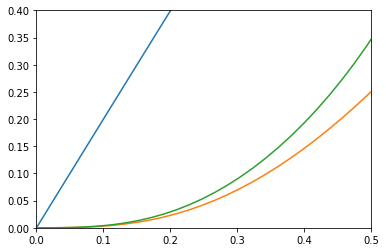

In [56]:
plt.plot(delPs, -T*deltas)
plt.plot(delPs, -T*delta1s)
plt.plot(delPs, -T*delta2s)
plt.xlim([0,0.5])
plt.ylim([0,0.4])